### **Reading Data From Kaggle**

In [4]:
from google.colab import files
files.upload()    # choose kaggle.json from your PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammedwaheed","key":"0d2c7066c6391fdaee251ee81abb528f"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition


 94% 764M/814M [00:04<00:01, 43.8MB/s]
100% 814M/814M [00:04<00:00, 201MB/s] 


In [7]:
!unzip -q dogs-vs-cats-redux-kernels-edition.zip


In [8]:
!ls


dogs-vs-cats-redux-kernels-edition.zip	sample_data	       test.zip
kaggle.json				sample_submission.csv  train.zip


In [9]:
!mkdir -p data/train
!mkdir -p data/test

!unzip -q train.zip -d data/train
!unzip -q test.zip -d data/test


In [10]:
!ls data/train | head


train


In [11]:
!ls data
!ls data/train
!ls data/train/train | head


test  train
train
cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg
cat.10003.jpg
cat.10004.jpg
cat.10005.jpg
cat.10006.jpg
cat.10007.jpg
cat.10008.jpg


### **Importing Libraries**

In [12]:
import cv2
import os
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [13]:
train_dir = "data/train/train"
test_dir  = "data/test/test"


### **Labling Data**

In [14]:
filenames = os.listdir(train_dir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df.head()

,filename,category
0,dog.9638.jpg,0
1,dog.10492.jpg,0
2,cat.562.jpg,1
3,cat.11045.jpg,1
4,dog.9582.jpg,0


In [16]:
df.tail()

,filename,category
24995,dog.643.jpg,0
24996,dog.11455.jpg,0
24997,cat.11777.jpg,1
24998,dog.6637.jpg,0
24999,dog.1182.jpg,0


### **Define Constants**

In [39]:

NUM_CLASSES = 2
CHANNELS = 3
Batch_Size=100
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
#RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
NUM_EPOCHS = 25
EARLY_STOP_PATIENCE = 10
LOSS_METRICS = ['accuracy']

### **Display Images**

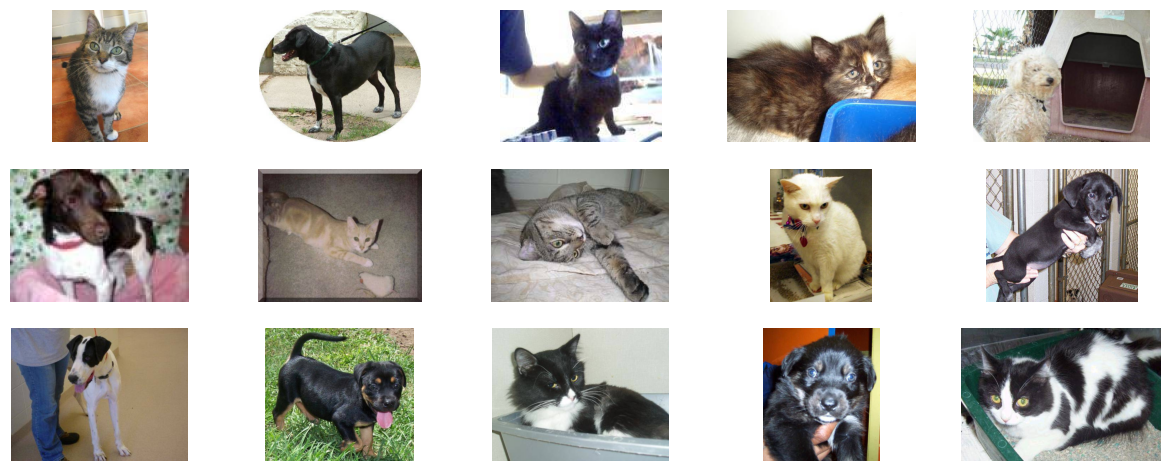

In [40]:
plt.figure(figsize=(15, 10))
for n, i in enumerate(np.random.randint(0, len(filenames), 15)):
    plt.subplot(5, 5, n + 1)
    sample = filenames[i]
    image_path = os.path.join(train_dir, sample)
    image = load_img(image_path)
    plt.imshow(image)
    plt.axis('off')
plt.show()

### **Building CNN Model**

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>


In [41]:


model = Sequential([

    ResNet50(include_top=False, weights='imagenet'),

    GlobalMaxPooling2D(),

    Dense(NUM_CLASSES, activation='softmax')
])

model.layers[0].trainable = False


### **optimizer**

In [42]:
optimizer = SGD(learning_rate=0.001, momentum=0.9,nesterov =True)

In [44]:
model.compile(optimizer = optimizer, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [45]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, None, None,     │    23,587,712 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### **Callbacks**
**Early Stopping:**

######**To prevent overfitting we will stop the learning after 10 epochs and val_loss value not decreased**
____________________________________

**Checkpointing :**
######**Continuously saves the model only when it achieves a new best score on the monitored metric**

In [46]:
early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath="CNN.model.keras", monitor = 'val_loss', save_best_only = True, mode = 'auto')

### **Preparing Data**

Since we are using an ImageDataGenerator with class_mode="categorical", the generator expects the class labels to be strings, not integers.

In [47]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'})

#### Splitting  Training Data Into **Train** And **Validation**

In [48]:
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [49]:
print('train_df Shape is : ', train_df.shape)
print("="*36)
print('test_df Shape is : ', val_df.shape)

train_df Shape is :  (20000, 2)
test_df Shape is :  (5000, 2)


### **Data Augmentation**

In [50]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=Batch_Size,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=Batch_Size,
    class_mode='categorical'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


### **Fitting The Model**

In [51]:
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpointer, early_stopper]
)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 228ms/step - accuracy: 0.9156 - loss: 1.3737 - val_accuracy: 0.9546 - val_loss: 0.3896
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 207ms/step - accuracy: 0.9630 - loss: 0.2761 - val_accuracy: 0.9598 - val_loss: 0.2732
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9640 - loss: 0.2334 - val_accuracy: 0.9612 - val_loss: 0.2608
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - accuracy: 0.9631 - loss: 0.1922 - val_accuracy: 0.9526 - val_loss: 0.3205
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.9723 - loss: 0.1326 - val_accuracy: 0.9564 - val_loss: 0.2786
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9738 - loss: 0.1224 - val_accuracy: 0.9580 - val_loss: 0.2657
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.9757 - loss: 0.1121 - val_accuracy: 0.9480 - val_loss: 0.3350
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.9761 - loss: 0

### **Loading Model**

In [53]:
import keras
Best_Model = keras.models.load_model("CNN.model.keras")

### **Evaluation**

In [54]:
y_pred = Best_Model.predict(validation_generator)
print("Prediction Shape is {}".format(y_pred.shape))

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step
Prediction Shape is (5000, 2)


In [55]:
# --- Predict on validation generator ---
y_pred = Best_Model.predict(validation_generator)
print("Prediction Shape:", y_pred.shape)
# Example: (num_samples, num_classes)

# --- Get one batch from training generator ---
X_batch, y_batch = next(train_generator)

# --- Predictions for that batch ---
batch_pred = Best_Model.predict(X_batch)

# --- Convert softmax output to class index ---
y_pred_classes = batch_pred.argmax(axis=1)

# --- Convert true labels ---
y_true = y_batch.argmax(axis=1)

# --- Print comparison ---
print("Predicted labels: ", y_pred_classes[:20])
print("True labels:      ", y_true[:20])


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step
Prediction Shape: (5000, 2)
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Predicted labels:  [1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0]
True labels:       [1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0]


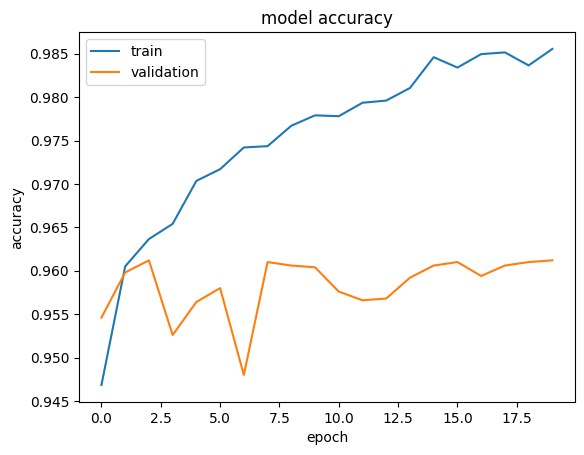

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

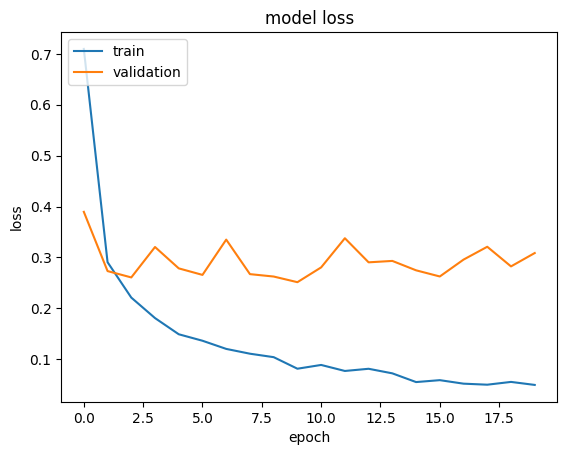

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Prepare Testing Data**

In [58]:
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({'filename': test_filenames})
nb_samples = test_df.shape[0]
nb_samples

12500

### **Test Generator**

In [84]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    test_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=Batch_Size,
    shuffle=False
)

Found 12500 validated image filenames.


### **Testing Model**

In [86]:
pred = Best_Model.predict(test_generator, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step


In [87]:
pred_classes = np.argmax(pred,axis=1)


In [88]:
label_map = {0: "cat", 1: "dog"}
pred_labels = [label_map[i] for i in pred_classes]

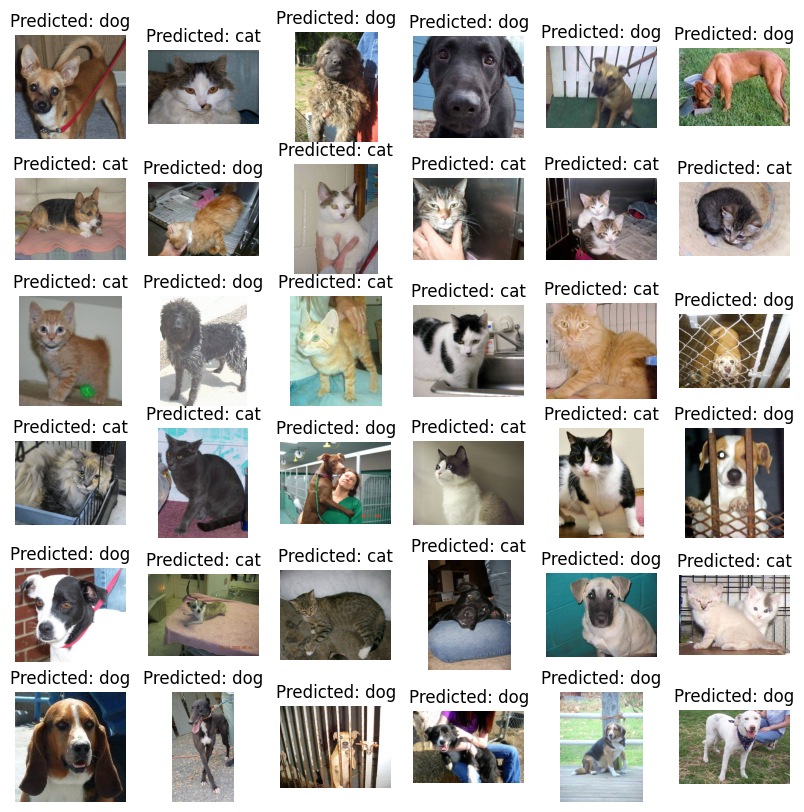

In [91]:
f, ax = plt.subplots(6, 6, figsize=(10, 10))

for idx in range(36):
    filename = test_generator.filenames[idx]
    full_path = os.path.join(test_dir, filename)

    imgBGR = cv2.imread(full_path)
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

    predicted_class = "dog" if pred_classes[idx] == 1 else "cat"

    ax[idx // 6, idx % 6].imshow(imgRGB)
    ax[idx // 6, idx % 6].axis("off")
    ax[idx // 6, idx % 6].set_title(f"Predicted: {predicted_class}")

plt.show()
